# 03. Evaluation Methods for Marketing Mix Models

How do you know if your MMM is good? This notebook covers the evaluation metrics and diagnostic methods used to assess model quality.

## Table of Contents
1. [Model Fit Metrics](#1-model-fit-metrics)
2. [Bayesian Diagnostics](#2-bayesian-diagnostics)
3. [Cross-Validation](#3-cross-validation)
4. [Residual Analysis](#4-residual-analysis)
5. [Business Validation](#5-business-validation)
6. [Calibration with Experiments](#6-calibration-with-experiments)

---

## 1. Model Fit Metrics

### Standard Regression Metrics

| Metric | Formula | Interpretation | Good Value |
|--------|---------|----------------|------------|
| **MAPE** | mean(abs(y - y_hat) / y) * 100 | % error, scale-independent | < 15% |
| **RMSE** | sqrt(mean((y - y_hat)^2)) | Error in original units | Context-dependent |
| **MAE** | mean(abs(y - y_hat)) | Average absolute error | Context-dependent |
| **R-squared** | 1 - SS_res/SS_tot | Variance explained | > 0.8 |

### Why Multiple Metrics?

- **MAPE**: Good for comparing across different scales, but sensitive to small values
- **RMSE**: Penalizes large errors more (squared), good for detecting outliers
- **MAE**: More robust to outliers than RMSE
- **R-squared**: Overall explanatory power, but can be misleading with many predictors

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
sys.path.insert(0, '../src')

# Import evaluation functions
from models.evaluation import (
    compute_mape, compute_rmse, compute_mae, compute_r2,
    evaluate_model, compute_residual_diagnostics
)

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

print("Evaluation functions loaded!")

/Users/varma/Desktop/Git/Unified-M/.venv/lib/python3.11/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(
/Users/varma/Desktop/Git/Unified-M/.venv/lib/python3.11/site-packages/pymc_marketing/pytensor_utils.py:34: FutureWarning: `pytensor.graph.basic.ancestors` was moved to `pytensor.graph.traversal.ancestors`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import ancestors
2026-02-05 19:28:35.011 | WARNING  | mmm.model:<module>:29 - pymc-marketing not installed. Using baseline model.


Evaluation functions loaded!


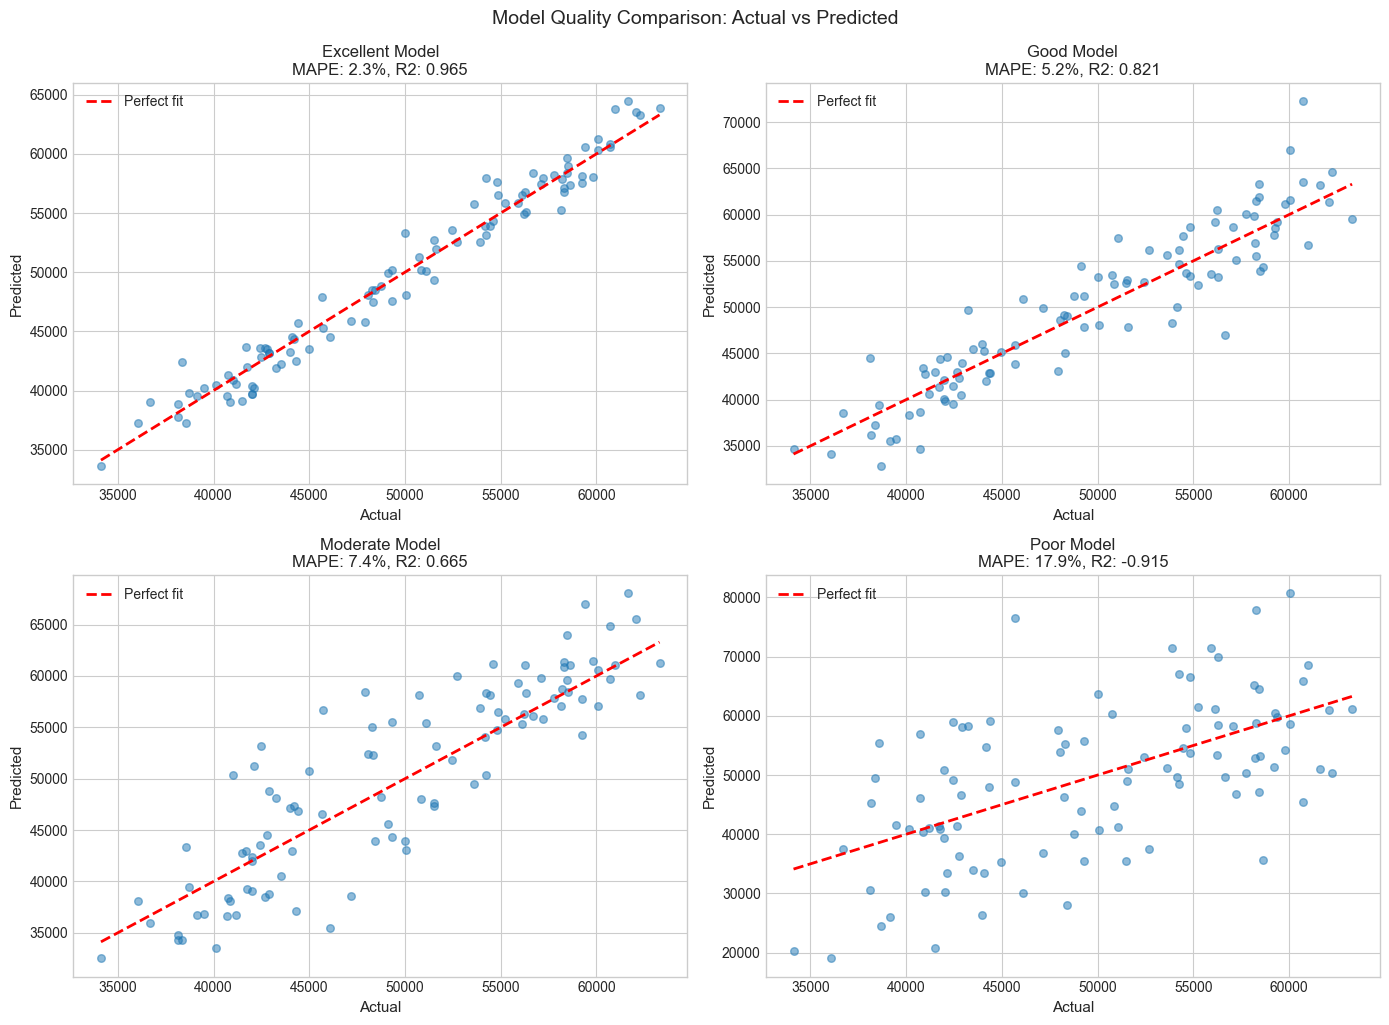


Metrics Summary:
Excellent: MAPE=2.34%, RMSE=1,424, R2=0.965
Good: MAPE=5.17%, RMSE=3,242, R2=0.821
Moderate: MAPE=7.41%, RMSE=4,431, R2=0.665
Poor: MAPE=17.89%, RMSE=10,599, R2=-0.915


In [2]:
# Generate example actual vs predicted data
n = 100
y_true = 50000 + 10000 * np.sin(np.linspace(0, 4*np.pi, n)) + np.random.normal(0, 3000, n)

# Simulate different model qualities
noise_levels = {'Excellent': 1500, 'Good': 3000, 'Moderate': 5000, 'Poor': 10000}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

results = {}
for idx, (quality, noise) in enumerate(noise_levels.items()):
    y_pred = y_true + np.random.normal(0, noise, n)
    
    # Calculate metrics
    metrics = evaluate_model(y_true, y_pred)
    results[quality] = metrics
    
    # Plot actual vs predicted
    axes[idx].scatter(y_true, y_pred, alpha=0.5, s=30)
    axes[idx].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                   'r--', linewidth=2, label='Perfect fit')
    axes[idx].set_xlabel('Actual', fontsize=11)
    axes[idx].set_ylabel('Predicted', fontsize=11)
    title = f"{quality} Model\nMAPE: {metrics['mape']:.1f}%, R2: {metrics['r2']:.3f}"
    axes[idx].set_title(title, fontsize=12)
    axes[idx].legend()

plt.tight_layout()
plt.suptitle('Model Quality Comparison: Actual vs Predicted', y=1.02, fontsize=14)
plt.show()

# Summary table
print("\nMetrics Summary:")
print("=" * 60)
for quality, m in results.items():
    print(f"{quality}: MAPE={m['mape']:.2f}%, RMSE={m['rmse']:,.0f}, R2={m['r2']:.3f}")

## 2. Bayesian Diagnostics

When using Bayesian MMM (PyMC), additional diagnostics are crucial:

### Key Convergence Metrics

| Metric | Target | What It Means |
|--------|--------|---------------|
| **R-hat** | < 1.01 | Chains have converged to same distribution |
| **ESS (bulk)** | > 400 | Enough effective samples for reliable estimates |
| **ESS (tail)** | > 400 | Reliable tail probabilities |
| **Divergences** | 0 | No sampling problems |
| **Max tree depth** | Not hitting limit | Sampler exploring efficiently |

### What to Do If Diagnostics Fail

| Problem | Symptom | Solution |
|---------|---------|----------|
| Non-convergence | R-hat > 1.1 | More samples, reparameterize |
| Low ESS | ESS < 100 | More samples, thin chains |
| Divergences | > 0 | Increase target_accept, reparameterize |
| Slow mixing | High autocorrelation | Better priors, centered/non-centered |

## 3. Time Series Cross-Validation

Standard k-fold CV doesn't work for time series because it leaks future information into the past. Instead, use **expanding window** or **rolling window** CV.

### Expanding Window CV

```
Fold 1: Train [----] Test [--]
Fold 2: Train [------] Test [--]
Fold 3: Train [--------] Test [--]
Fold 4: Train [----------] Test [--]
```

### Why Time Series CV Matters

1. **Respects temporal ordering**: Never train on future data
2. **Tests generalization**: How well does model predict forward?
3. **Detects overfitting**: Model might memorize training patterns
4. **Reveals stability**: Are coefficients stable over time?

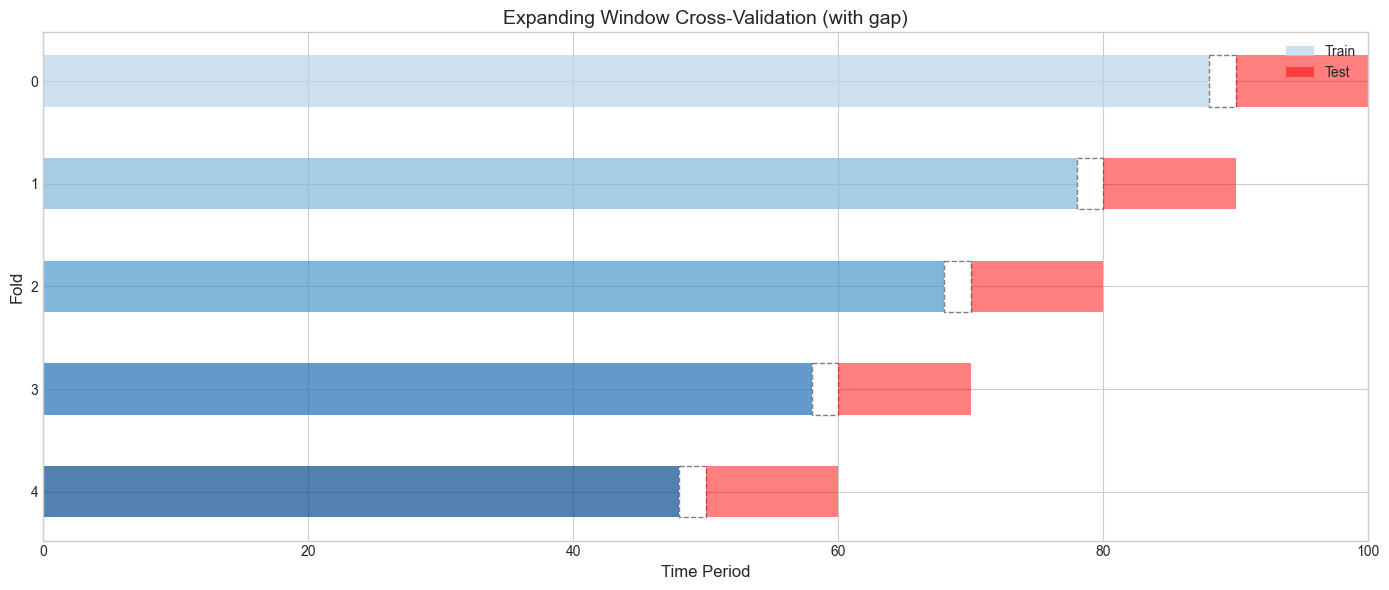

\nKey points:
- Training set grows with each fold
- Gap prevents data leakage from sequential correlation
- Always testing on future data relative to training


In [3]:
# Demonstrate time series cross-validation
n_total = 100
n_splits = 5
test_size = 10
gap = 2  # Gap between train and test to avoid leakage

fig, ax = plt.subplots(figsize=(14, 6))

colors = plt.cm.Blues(np.linspace(0.3, 0.9, n_splits))

for fold in range(n_splits):
    # Calculate split points
    test_end = n_total - fold * test_size
    test_start = test_end - test_size
    train_end = test_start - gap
    
    # Plot training period
    ax.barh(fold, train_end, left=0, height=0.5, color=colors[fold], alpha=0.7, label='Train' if fold == 0 else '')
    
    # Plot gap
    ax.barh(fold, gap, left=train_end, height=0.5, color='white', edgecolor='gray', linestyle='--')
    
    # Plot test period
    ax.barh(fold, test_size, left=test_start, height=0.5, color='red', alpha=0.5, label='Test' if fold == 0 else '')

ax.set_xlabel('Time Period', fontsize=12)
ax.set_ylabel('Fold', fontsize=12)
ax.set_title('Expanding Window Cross-Validation (with gap)', fontsize=14)
ax.legend(loc='upper right')
ax.set_xlim(0, n_total)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

print("\\nKey points:")
print("- Training set grows with each fold")
print("- Gap prevents data leakage from sequential correlation")
print("- Always testing on future data relative to training")

## 4. Residual Analysis

Residuals (actual - predicted) reveal model problems:

### What to Check

| Pattern | Problem | Solution |
|---------|---------|----------|
| Trend in residuals | Missing trend component | Add trend term |
| Seasonality | Missing seasonality | Add Fourier terms |
| Heteroscedasticity | Variance changes | Log transform target |
| Autocorrelation | Missing dynamics | Add lagged terms |
| Non-normality | Wrong distributional assumption | Different likelihood |

### Key Diagnostics

- **Durbin-Watson**: Tests for autocorrelation (target: close to 2)
- **Skewness**: Tests for symmetry (target: close to 0)
- **Kurtosis**: Tests for heavy tails (target: close to 0)

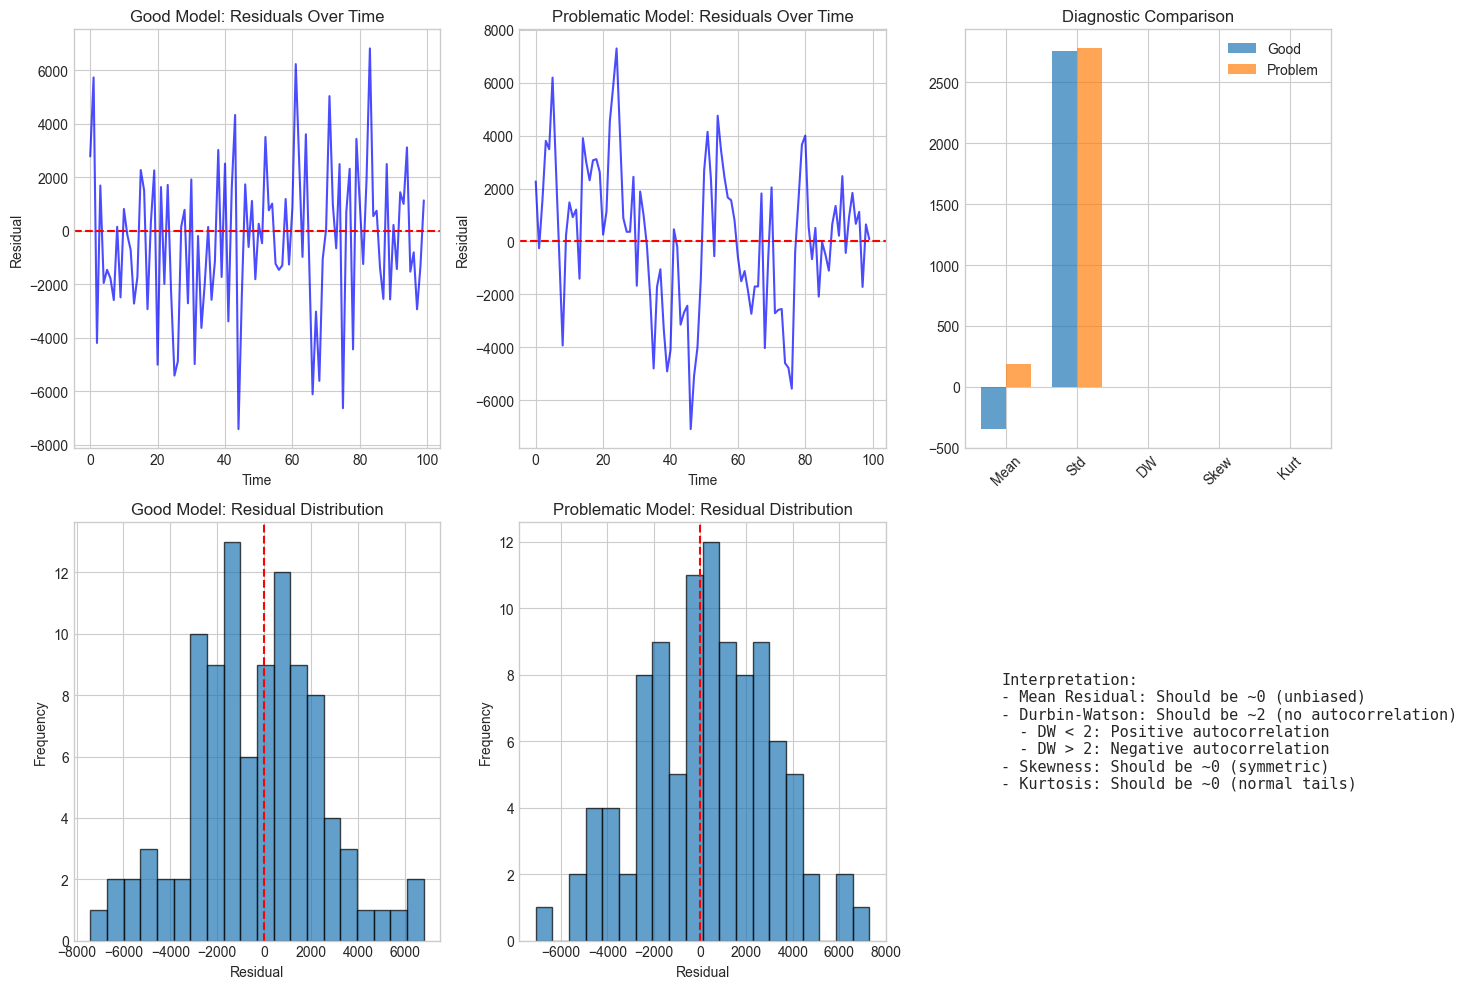


Diagnostic Values:

Good Model:
  mean_residual: -345.9168
  std_residual: 2756.7248
  skewness: -0.0354
  kurtosis: 0.0940
  durbin_watson: 2.0466

Problematic Model:
  mean_residual: 183.9560
  std_residual: 2776.6264
  skewness: -0.1220
  kurtosis: -0.1673
  durbin_watson: 0.7026


In [4]:
# Demonstrate residual diagnostics
# Create example with good and bad residuals

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Good model residuals (random, no pattern)
residuals_good = np.random.normal(0, 3000, 100)

# Bad model residuals (has autocorrelation)
residuals_bad = np.zeros(100)
residuals_bad[0] = np.random.normal(0, 3000)
for i in range(1, 100):
    residuals_bad[i] = 0.7 * residuals_bad[i-1] + np.random.normal(0, 2000)

for col, (residuals, title) in enumerate([(residuals_good, 'Good Model'), (residuals_bad, 'Problematic Model')]):
    # Plot 1: Residuals over time
    axes[0, col].plot(residuals, 'b-', alpha=0.7)
    axes[0, col].axhline(0, color='r', linestyle='--')
    axes[0, col].set_xlabel('Time')
    axes[0, col].set_ylabel('Residual')
    axes[0, col].set_title(f'{title}: Residuals Over Time')
    
    # Plot 2: Residual distribution
    axes[1, col].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
    axes[1, col].axvline(0, color='r', linestyle='--')
    axes[1, col].set_xlabel('Residual')
    axes[1, col].set_ylabel('Frequency')
    axes[1, col].set_title(f'{title}: Residual Distribution')

# Plot 3: Comparison of diagnostics
diagnostics = {
    'Good Model': compute_residual_diagnostics(np.zeros(100), -residuals_good),
    'Problematic Model': compute_residual_diagnostics(np.zeros(100), -residuals_bad),
}

metrics = ['mean_residual', 'std_residual', 'durbin_watson', 'skewness', 'kurtosis']
x = np.arange(len(metrics))
width = 0.35

axes[0, 2].bar(x - width/2, [diagnostics['Good Model'][m] for m in metrics], width, label='Good', alpha=0.7)
axes[0, 2].bar(x + width/2, [diagnostics['Problematic Model'][m] for m in metrics], width, label='Problem', alpha=0.7)
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(['Mean', 'Std', 'DW', 'Skew', 'Kurt'], rotation=45)
axes[0, 2].set_title('Diagnostic Comparison')
axes[0, 2].legend()

# Remove empty subplot
axes[1, 2].axis('off')

# Add interpretation text
interpretation = '''
Interpretation:
- Mean Residual: Should be ~0 (unbiased)
- Durbin-Watson: Should be ~2 (no autocorrelation)
  - DW < 2: Positive autocorrelation
  - DW > 2: Negative autocorrelation
- Skewness: Should be ~0 (symmetric)
- Kurtosis: Should be ~0 (normal tails)
'''
axes[1, 2].text(0.1, 0.5, interpretation, fontsize=11, family='monospace',
                transform=axes[1, 2].transAxes, verticalalignment='center')

plt.tight_layout()
plt.show()

print("\nDiagnostic Values:")
print("=" * 50)
for model, diag in diagnostics.items():
    print(f"\n{model}:")
    for k, v in diag.items():
        print(f"  {k}: {v:.4f}")

## 5. Business Validation

Statistical metrics aren't enough. You must validate against business intuition:

### Sanity Checks

| Check | Question | Red Flag |
|-------|----------|----------|
| **ROI Reasonability** | Are channel ROIs plausible? | ROI > 10x or < 0 |
| **Contribution Shares** | Do shares match business understanding? | Organic is 0% |
| **Trend Direction** | Are trends in expected direction? | Revenue growing, model shows decline |
| **Seasonality** | Does seasonality match known patterns? | No Black Friday spike |
| **Coefficients** | Are signs correct? | Negative coefficient for paid media |

### Stakeholder Validation Questions

1. "Does this match your intuition about channel effectiveness?"
2. "Are there any known events the model should capture?"
3. "Does the baseline level seem reasonable?"
4. "Would you trust these results for budget decisions?"

## 6. Calibration with Experiments

The gold standard: compare MMM estimates to incrementality test results.

### Calibration Process

1. Run incrementality test on channel (e.g., geo-lift)
2. Get test result: "TV lift = 8% +/- 3%"
3. Compare to MMM estimate for same period
4. If different: adjust model or fusion weights

### What Discrepancies Mean

| MMM vs Test | Possible Cause | Action |
|-------------|----------------|--------|
| MMM higher | MMM capturing correlation, not causation | Add controls, calibrate down |
| MMM lower | Test period unusual, MMM missing dynamics | Review test validity, calibrate up |
| Both align | Good! | Increase confidence |

## Summary

A good MMM should pass:

1. Statistical tests (MAPE < 15%, R-squared > 0.8)
2. Bayesian diagnostics (R-hat < 1.01, no divergences)
3. Cross-validation (stable out-of-sample performance)
4. Residual analysis (no patterns, DW close to 2)
5. Business validation (makes intuitive sense)
6. Experimental calibration (aligns with test results)

Only when all these pass should you use the model for budget decisions!